In [1]:
import os

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from openpyxl import Workbook, load_workbook

sc.set_figure_params(dpi=80)

# OSPP

Data from the paper [Cross-platform Clinical Proteomics using the Charité Open Standard for Plasma Proteomics (OSPP)](https://www.medrxiv.org/content/10.1101/2024.05.10.24307167v1). Data available from [here](https://data.mendeley.com/datasets/f8kbg4798h/1).

Workflows:

- nThermo: nanoflow attached Exploris 480, (MS1 quantification; MS2 quantification)
- hZSWATH: analytical flow attached ZenoTOF 7600, Zeno SWATH DIA
- hZsSWATH: analytical flow attached ZenoTOF 7600, scanning DIA
- uZSWATH: µflow attached ZenoTOF 7600, Zeno SWATH DIA

In [2]:
DATA_DIR_PATH = "../../data/raw/ospp/Data output/"

In [3]:
DIR_nThermo = "sample_OSPP_nanoflow Exploris480"
DIR_hZSWATH_hZsSWATH = "sample_OSPP_analyticalflow ZenoTOF"
DIR_uZSWATH = "sample_OSPP_microflow ZenoTOF"

In [4]:
def renamer_filepath(name: str) -> str:
    return name.lower().replace(" ", "_").replace("-", "_")


def renamer(name: str) -> str:
    return name.lower().replace(" ", "_").replace(".", "_").replace("-", "_")


def rename_df_inplace(df):
    df.columns = df.columns.map(renamer)


def rename_adata_inplace(adata):
    adata.obs.columns = [renamer(col) for col in adata.obs.columns]
    adata.var.columns = [renamer(col) for col in adata.var.columns]

    uns = adata.uns.copy()
    adata.uns = {}
    for key, val in uns.items():
        adata.uns[renamer(key)] = val

In [5]:
def extract(identifiers: list[list[str]], index: int) -> list[str]:
    return [ident[index] for ident in identifiers]

### Map sample position to COVID-19 severity

In [6]:
META_DATA_DIR_PATH = "../../data/raw/ospp/media-1/Tables"
DIR_METADATA = "Supplementary Table 3_metadata.xlsx"

PATH_METADATA = os.path.join(META_DATA_DIR_PATH, DIR_METADATA)

In [7]:
wb = load_workbook(PATH_METADATA)

In [8]:
ws_auxid_severity = wb["meta data for study cohort"]
ws_position_auxid = wb["metadata for exploris480 sample"]

In [9]:
df_auxid_severity = pd.DataFrame(ws_auxid_severity.values)
df_auxid_severity = df_auxid_severity.iloc[1:]
df_auxid_severity = df_auxid_severity.iloc[:, :3]

df_auxid_severity.columns = df_auxid_severity.iloc[0]
df_auxid_severity = df_auxid_severity[1:]
df_auxid_severity.reset_index(drop=True, inplace=True)

df_auxid_severity.set_index("Aux.Id", inplace=True)

In [10]:
df_pos_to_aux = pd.DataFrame(ws_position_auxid.values)
df_pos_to_aux.columns = df_pos_to_aux.iloc[0]
df_pos_to_aux = df_pos_to_aux[1:]
df_pos_to_aux.reset_index(drop=True, inplace=True)

df_pos_to_aux = df_pos_to_aux.map(str)
df_pos_to_aux["Sample"] = df_pos_to_aux["Sample"].apply(lambda x: x.split(".")[0])

df_pos_to_aux.set_index("Sample", inplace=True)

In [11]:
df_meta = df_pos_to_aux.join(df_auxid_severity, how="inner", validate="one_to_one")

df_meta["Position"] = df_meta["Position"].map(renamer)
df_meta.set_index("Position", inplace=True)

In [12]:
df_meta.head()

,WHO grade,Severity
Position,,
a1,4,moderate
a2,0,healthy
a3,0,healthy
a4,0,healthy
a5,3,mild


In [13]:
nThermo_position_to_severity = dict(zip(df_meta.index, df_meta["Severity"], strict=True))

In [14]:
auxid_to_severity = dict(zip(df_auxid_severity.index.str.lower(), df_auxid_severity["Severity"], strict=True))

## nThermo

In [15]:
PATH_nThermo = os.path.join(DATA_DIR_PATH, DIR_nThermo, "report.pr_matrix.tsv")

In [16]:
df_raw = pd.read_csv(PATH_nThermo, sep="\t")

In [17]:
df_var = df_raw.iloc[:, :10]
df_X = df_raw.drop(columns=df_var.columns.values)
df_X = df_X.T

rename_df_inplace(df_var)
assert df_var["precursor_id"].nunique() == df_var.shape[0]

df_var.set_index("precursor_id", inplace=True)

In [18]:
def renamer(name: str) -> str:
    return name.lower().replace(" ", "_").replace(".", "_").replace("-", "_")

file_description = [name.split("/")[-1] for name in df_X.index.copy().map(renamer)]
identifiers = [name.split("_") for name in file_description]

file_name = df_X.index.copy().map(renamer_filepath)

In [19]:
identifier_lengths = np.array([len(ident) for ident in identifiers])
assert np.all(identifier_lengths == identifier_lengths[0])

In [20]:
position = extract(identifiers, 8)
severity = list(map(nThermo_position_to_severity.get, position))

sample_type = extract(identifiers, 9)
sample_type = ["pool" if sample == "poolsample" else sample for sample in sample_type ]

obs_attributes = {
    "position": position,
    "severity": severity,
    "sample_type": sample_type,
    "replicate": extract(identifiers, 10),
    "file_name": file_name,
    "method": "nthermo"
}

In [21]:
obs = pd.DataFrame(obs_attributes)
obs.index = [f"s{i}" for i in range(obs.shape[0])]

var = df_var

adata = ad.AnnData(X=df_X.values, obs=obs, var=var)

In [22]:
adata.X[np.isnan(adata.X)] = 0
sc.pp.log1p(adata)
adata.X[adata.X == 0] = np.nan

In [23]:
adata.layers["raw"] = adata.X.copy()

In [24]:
adata

AnnData object with n_obs × n_vars = 52 × 734
    obs: 'position', 'severity', 'sample_type', 'replicate', 'file_name', 'method'
    var: 'protein_group', 'protein_ids', 'protein_names', 'genes', 'first_protein_description', 'proteotypic', 'stripped_sequence', 'modified_sequence', 'precursor_charge'
    uns: 'log1p'
    layers: 'raw'

In [25]:
adata_nthermo = adata.copy()

Let's look at the data.

In [26]:
missing = np.isnan(adata.layers["raw"]).sum() / adata.layers["raw"].size
print(f"Missing values: {missing:.2%}")

Missing values: 12.95%


Text(0, 0.5, 'count')

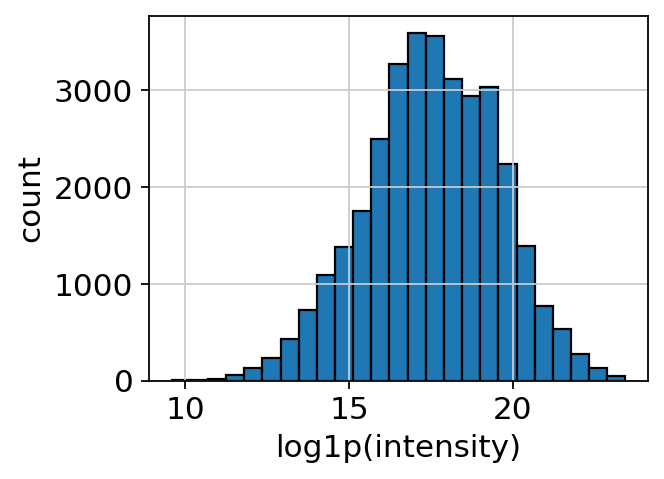

In [27]:
fig, ax = plt.subplots(figsize=(4, 3))

x = adata.layers["raw"].flatten()
x = x[~np.isnan(x)]
ax.hist(x, bins=25, edgecolor="black")
ax.set_xlabel("log1p(intensity)")
ax.set_ylabel("count")

In [28]:
adata.X = adata.layers["raw"].copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

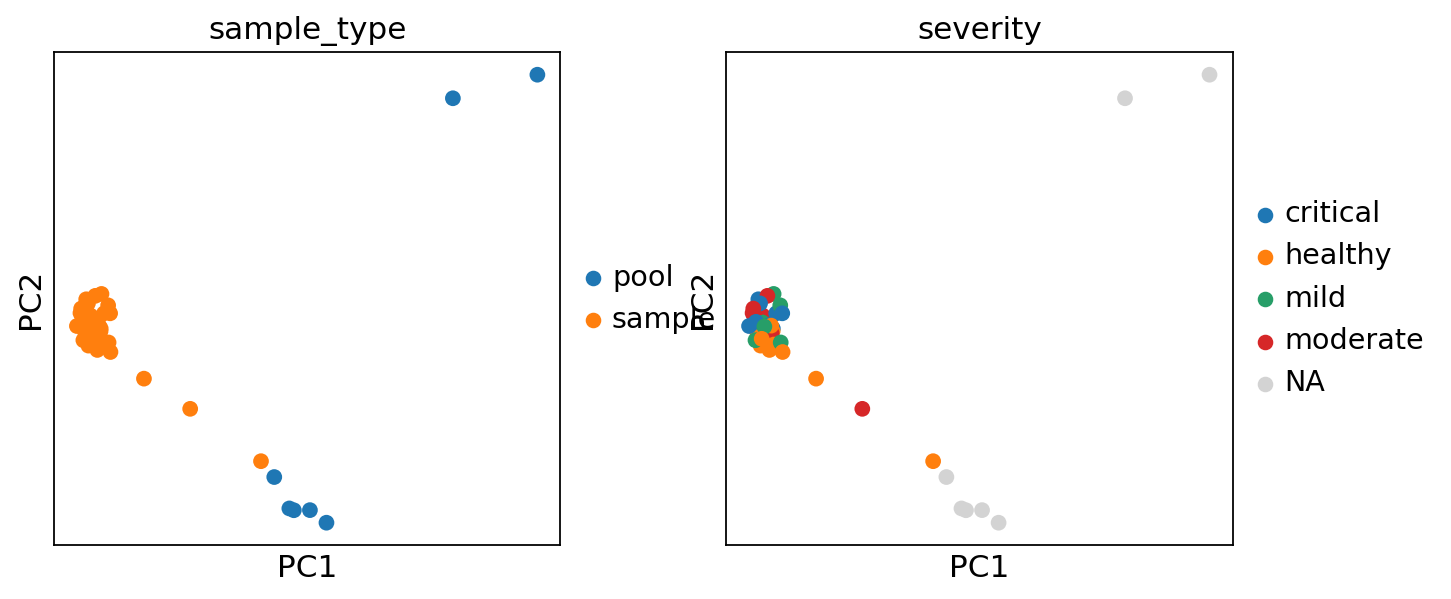

In [29]:
sc.pl.pca(adata, color=["sample_type", "severity"], size=200)

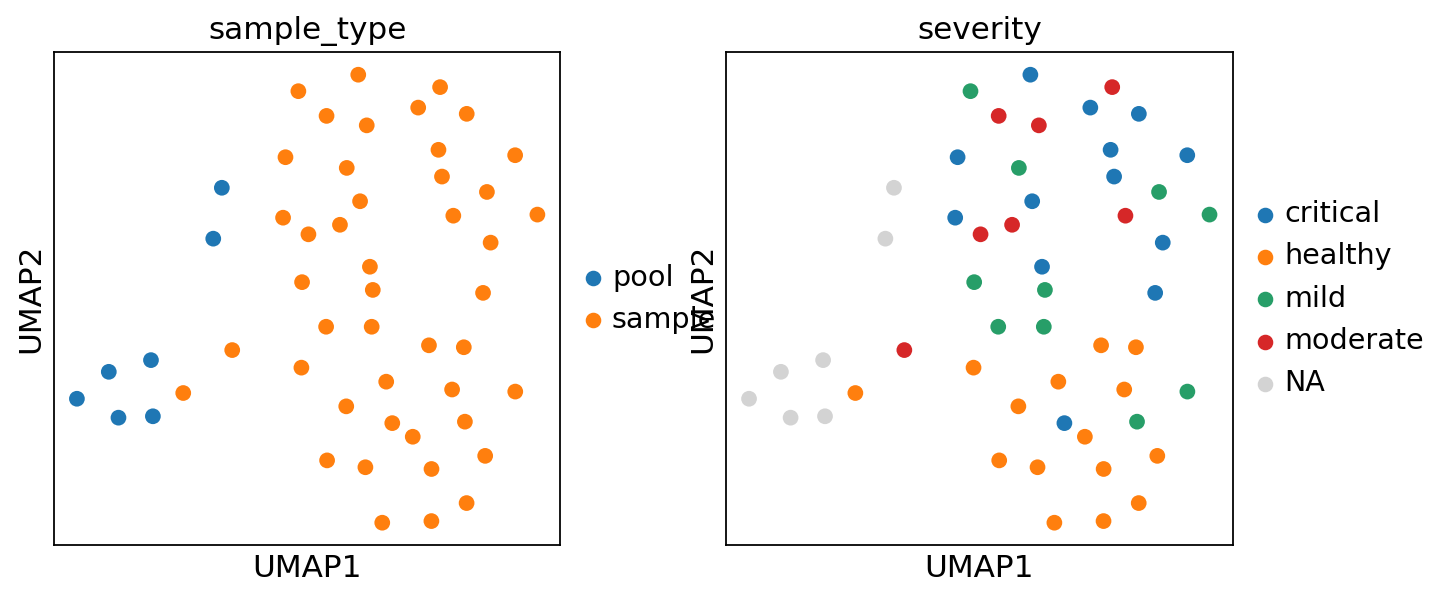

In [30]:
sc.pl.umap(adata, color=["sample_type", "severity"], ncols=2, size=200)

In [33]:
adata.obs.columns

Index(['position', 'severity', 'sample_type', 'replicate', 'file_name',
       'method'],
      dtype='object')

## hZSWATH + hZsSWATH

In [41]:
PATH_hZSWATH = os.path.join(DATA_DIR_PATH, DIR_hZSWATH_hZsSWATH, "report.pr_matrix.tsv")

In [42]:
df_raw = pd.read_csv(PATH_hZSWATH, sep="\t")

In [43]:
df_var = df_raw.iloc[:, :10]
df_X = df_raw.drop(columns=df_var.columns.values)
df_X = df_X.T

rename_df_inplace(df_var)
assert df_var["precursor_id"].nunique() == df_var.shape[0]

df_var.set_index("precursor_id", inplace=True)

In [44]:
def renamer(name: str) -> str:
    return name.lower().replace(" ", "_").replace(".", "_") #.replace("-", "_")


file_description = [name.split("/")[-1] for name in df_X.index.copy().map(renamer)]
identifiers = [name.split("_") for name in file_description]

file_name = df_X.index.copy().map(renamer_filepath)

In [45]:
mask = np.array([len(ident) == 11 for ident in identifiers])

print(f"Before: {len(identifiers)}")

# 1 sample is missing an element, so just remove it for now.
identifiers = [ident for i, ident in enumerate(identifiers) if mask[i]]

print(f"After: {len(identifiers)}")

Before: 104
After: 103


In [46]:
aux_or_pool = extract(identifiers, 7)
severity = [auxid_to_severity.get(auxid) for auxid in aux_or_pool]

obs_attributes = {
    "position": extract(identifiers, 5),
    "severity": severity,
    "sample_type": ["sample" if severity is not None else "pool" for severity in severity],
    "replicate": extract(identifiers, 8),
    "file_name": file_name[mask],
    "method": extract(identifiers, 6),
}

In [47]:
obs = pd.DataFrame(obs_attributes)
obs.index = [f"s{i}" for i in range(obs.shape[0])]

var = df_var

adata = ad.AnnData(X=df_X.values[mask], obs=obs, var=var)

In [48]:
adata.X[np.isnan(adata.X)] = 0
sc.pp.log1p(adata)
adata.X[adata.X == 0] = np.nan

In [49]:
adata.layers["raw"] = adata.X.copy()

In [50]:
adata

AnnData object with n_obs × n_vars = 103 × 564
    obs: 'position', 'severity', 'sample_type', 'replicate', 'file_name', 'method'
    var: 'protein_group', 'protein_ids', 'protein_names', 'genes', 'first_protein_description', 'proteotypic', 'stripped_sequence', 'modified_sequence', 'precursor_charge'
    uns: 'log1p'
    layers: 'raw'

In [51]:
adata_hzswath = adata.copy()

Let's look at the data.

In [52]:
missing = np.isnan(adata.layers["raw"]).sum() / adata.layers["raw"].size
print(f"Missing values: {missing:.2%}")

Missing values: 9.29%


Text(0, 0.5, 'count')

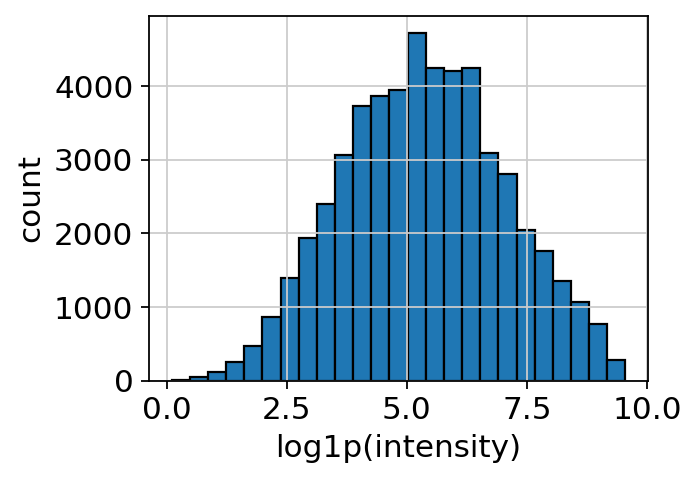

In [53]:
fig, ax = plt.subplots(figsize=(4, 3))

x = adata.layers["raw"].flatten()
x = x[~np.isnan(x)]
ax.hist(x, bins=25, edgecolor="black")
ax.set_xlabel("log1p(intensity)")
ax.set_ylabel("count")

In [54]:
adata.X = adata.layers["raw"].copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

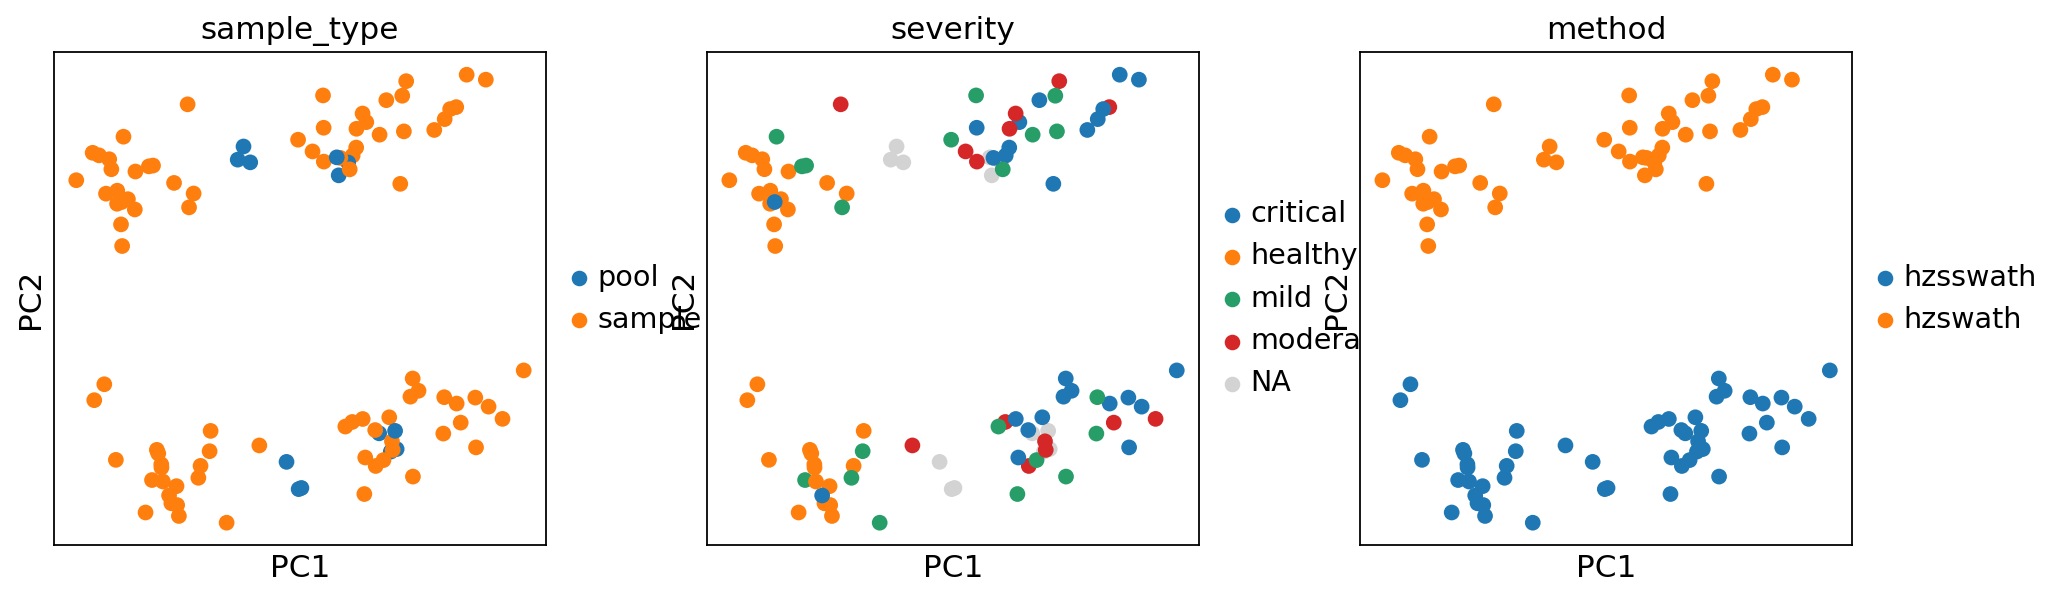

In [55]:
sc.pl.pca(adata, size=200, color=["sample_type", "severity", "method"], ncols=3)

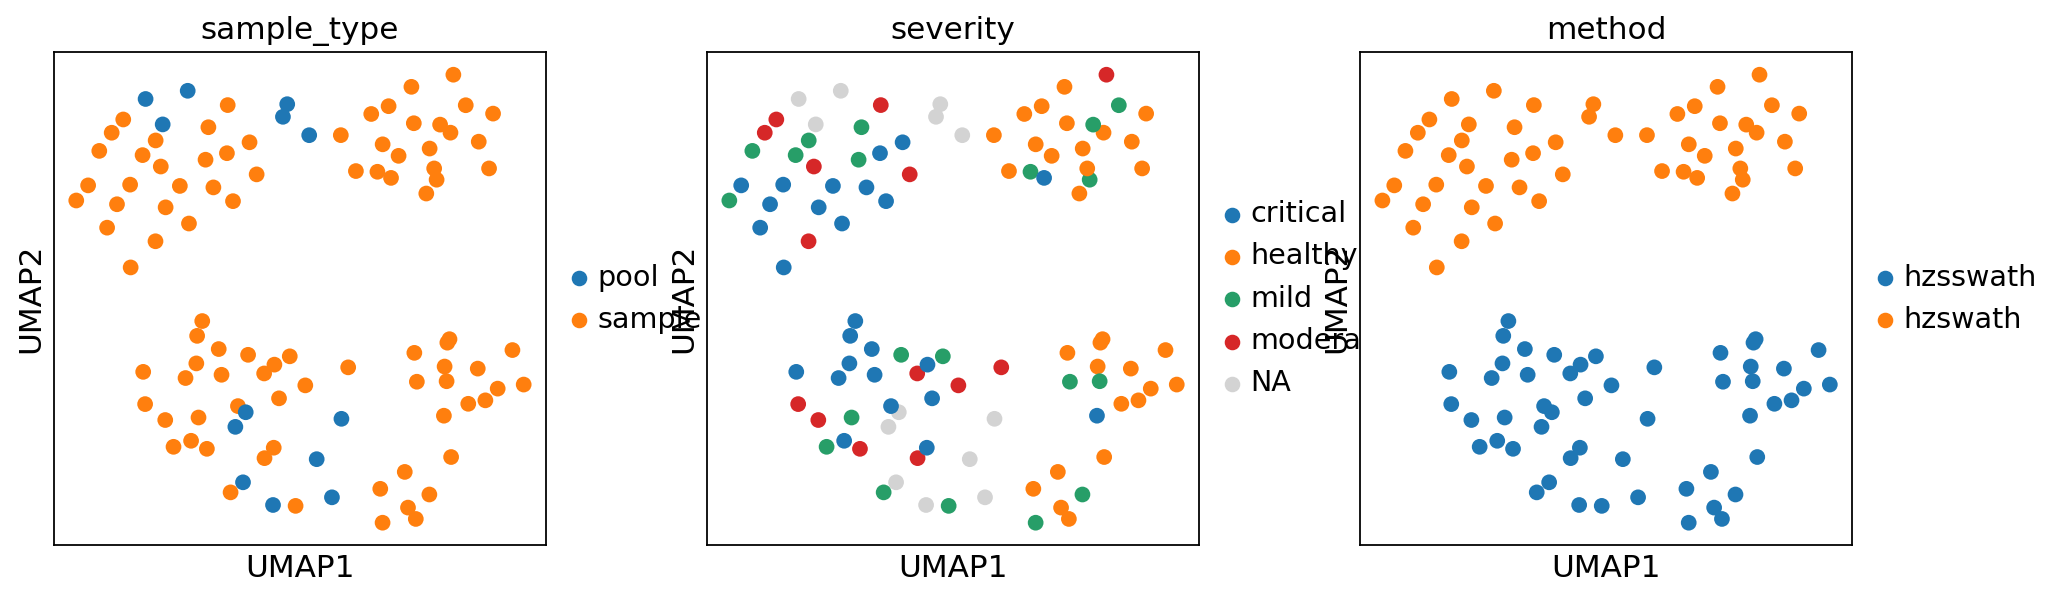

In [56]:
sc.pl.umap(adata, color=["sample_type", "severity", "method"], ncols=3, size=200)

## uZSWATH

In [57]:
PATH_uZSWATH = os.path.join(DATA_DIR_PATH, DIR_uZSWATH, "report.pr_matrix.tsv")

In [58]:
df_raw = pd.read_csv(PATH_uZSWATH, sep="\t")

In [59]:
df_var = df_raw.iloc[:, :10]
df_X = df_raw.drop(columns=df_var.columns.values)
df_X = df_X.T

rename_df_inplace(df_var)
assert df_var["precursor_id"].nunique() == df_var.shape[0]

df_var.set_index("precursor_id", inplace=True)

In [60]:
def renamer(name: str) -> str:
    return name.lower().replace(" ", "_").replace(".", "_")

file_name = df_X.index.copy().map(renamer)
file_description = [name.split("/")[-1] for name in file_name]
identifiers = [name.split("_") for name in file_description]

In [61]:
aux_or_pool = extract(identifiers, 7)
severity = [auxid_to_severity.get(auxid) for auxid in aux_or_pool]

obs_attributes = {
    "position": extract(identifiers, 5),
    "severity": severity,
    "sample_type": ["sample" if severity is not None else "pool" for severity in severity],
    "replicate": extract(identifiers, 8),
    "file_name": file_name,
    "method": "uzswath"
}

In [62]:
obs = pd.DataFrame(obs_attributes)
obs.index = [f"s{i}" for i in range(obs.shape[0])]

var = df_var

adata = ad.AnnData(X=df_X.values, obs=obs, var=var)

In [63]:
adata.X[np.isnan(adata.X)] = 0
sc.pp.log1p(adata)
adata.X[adata.X == 0] = np.nan

In [64]:
adata.layers["raw"] = adata.X.copy()

In [65]:
adata

AnnData object with n_obs × n_vars = 53 × 559
    obs: 'position', 'severity', 'sample_type', 'replicate', 'file_name', 'method'
    var: 'protein_group', 'protein_ids', 'protein_names', 'genes', 'first_protein_description', 'proteotypic', 'stripped_sequence', 'modified_sequence', 'precursor_charge'
    uns: 'log1p'
    layers: 'raw'

In [66]:
adata_uzswath = adata.copy()

Let's look at the data.

In [67]:
missing = np.isnan(adata.layers["raw"]).sum() / adata.layers["raw"].size
print(f"Missing values: {missing:.2%}")

Missing values: 3.74%


Text(0, 0.5, 'count')

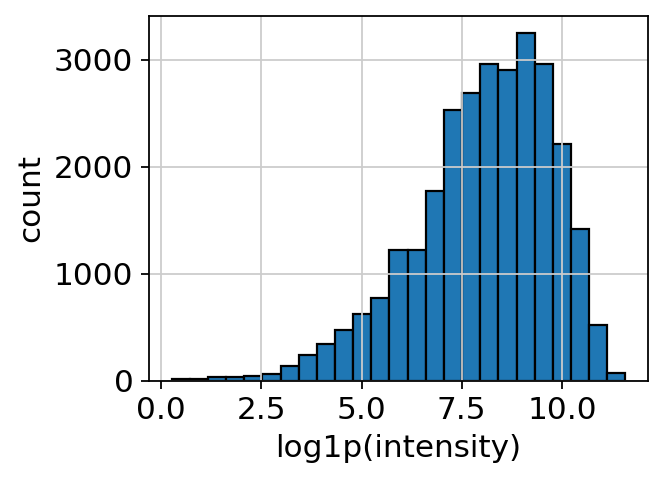

In [68]:
fig, ax = plt.subplots(figsize=(4, 3))

x = adata.layers["raw"].flatten()
x = x[~np.isnan(x)]
ax.hist(x, bins=25, edgecolor="black")
ax.set_xlabel("log1p(intensity)")
ax.set_ylabel("count")

In [69]:
adata.X = adata.layers["raw"].copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

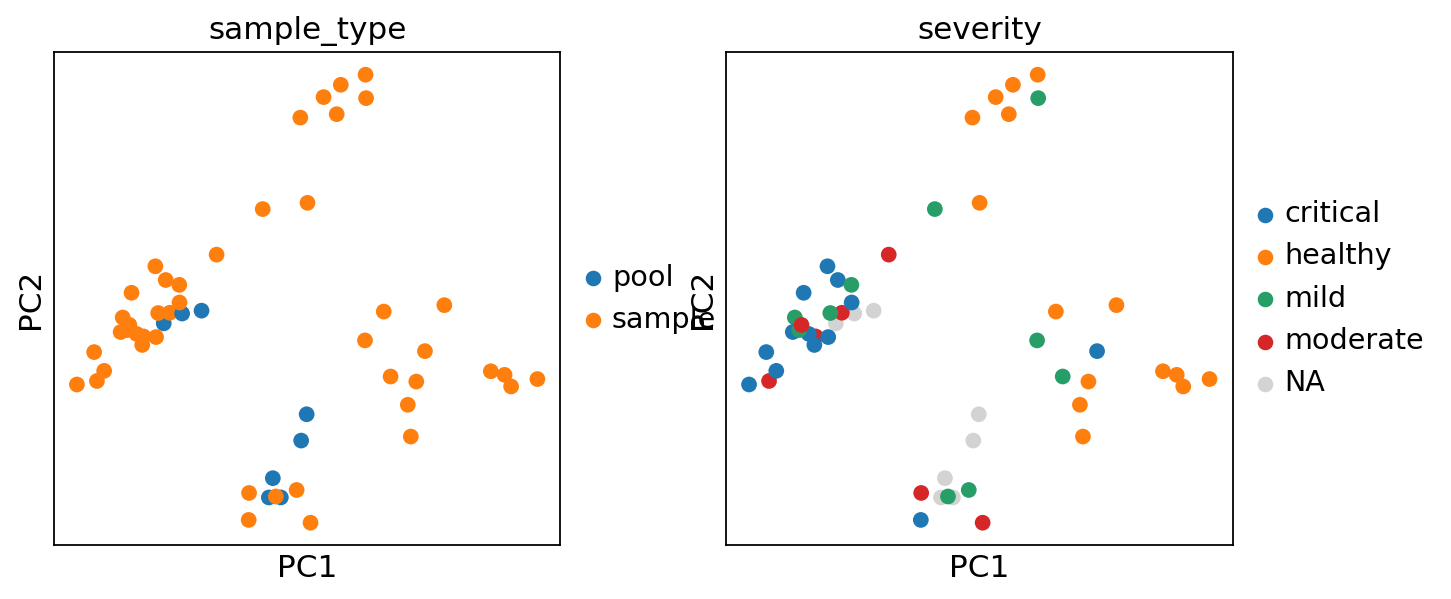

In [70]:
sc.pl.pca(adata, size=200, color=["sample_type", "severity"], ncols=2)

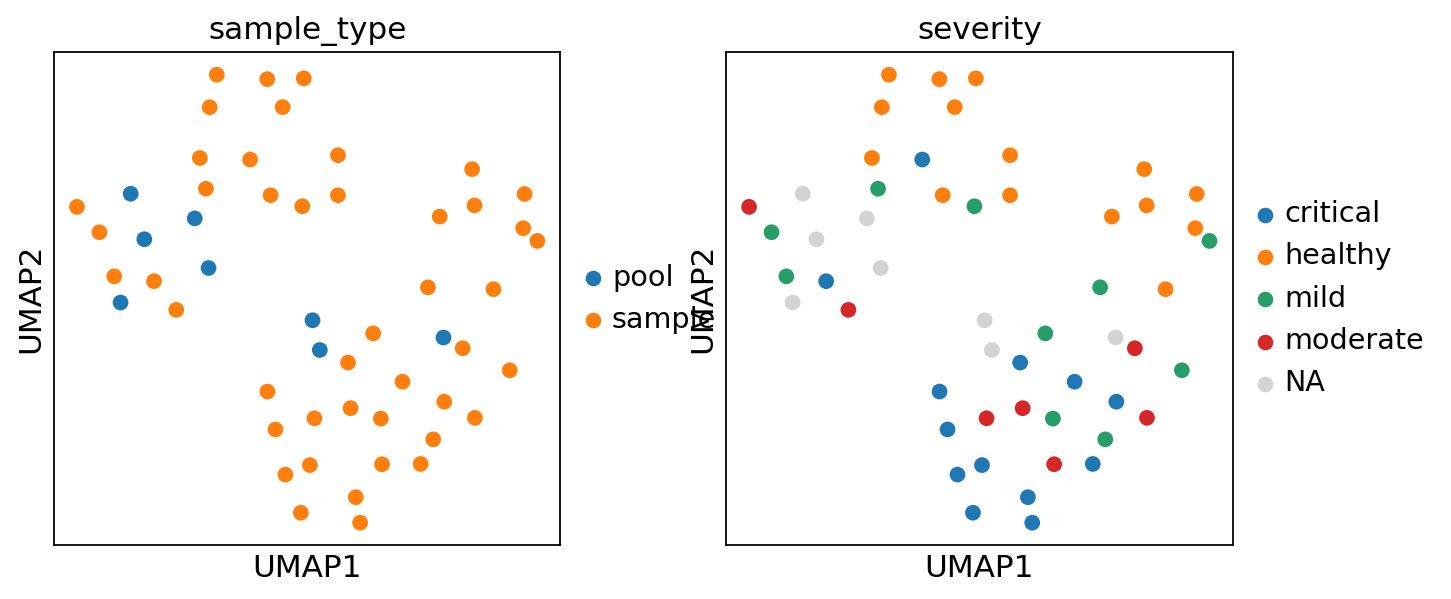

In [71]:
sc.pl.umap(adata, color=["sample_type", "severity"], ncols=2, size=200)

## Combine all datasets

In [72]:
adata_nthermo.var.head()

,protein_group,protein_ids,protein_names,genes,first_protein_description,proteotypic,stripped_sequence,modified_sequence,precursor_charge
precursor_id,,,,,,,,,
AADDTWEPFASGK(SILAC-K-L)1,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),1
AADDTWEPFASGK(SILAC-K-H)1,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),1
AADDTWEPFASGK(SILAC-K-L)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),2
AADDTWEPFASGK(SILAC-K-H)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),2
AADDTWEPFASGK(SILAC-K-L)3,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),3


In [73]:
adata_hzswath.var.head()

,protein_group,protein_ids,protein_names,genes,first_protein_description,proteotypic,stripped_sequence,modified_sequence,precursor_charge
precursor_id,,,,,,,,,
AADDTWEPFASGK(SILAC-K-L)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),2
AADDTWEPFASGK(SILAC-K-H)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),2
AADDTWEPFASGK(SILAC-K-L)3,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),3
AADDTWEPFASGK(SILAC-K-H)3,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),3
AAISGENAGLVR(SILAC-R-L)2,P19827,P19827;F8WAS2,ITIH1_HUMAN,ITIH1,Inter-alpha-trypsin inhibitor heavy chain H1,1,AAISGENAGLVR,AAISGENAGLVR(SILAC-R-L),2


In [74]:
adata_nthermo.var.head()

,protein_group,protein_ids,protein_names,genes,first_protein_description,proteotypic,stripped_sequence,modified_sequence,precursor_charge
precursor_id,,,,,,,,,
AADDTWEPFASGK(SILAC-K-L)1,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),1
AADDTWEPFASGK(SILAC-K-H)1,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),1
AADDTWEPFASGK(SILAC-K-L)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),2
AADDTWEPFASGK(SILAC-K-H)2,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-H),2
AADDTWEPFASGK(SILAC-K-L)3,P02766,P02766;A0A087WT59,TTHY_HUMAN,TTR,Transthyretin,1,AADDTWEPFASGK,AADDTWEPFASGK(SILAC-K-L),3


In [75]:
prot_nthermo = set(adata_nthermo.var.index.values)
prot_hzswath = set(adata_hzswath.var.index.values)
prot_uzswath = set(adata_uzswath.var.index.values)

common_proteins = list(prot_nthermo.intersection(prot_hzswath, prot_uzswath))

print(f"No. of common proteins: {len(common_proteins)}")

No. of common proteins: 541


In [76]:
adata_nthermo2 = adata_nthermo[:, common_proteins].copy()
adata_hzswath2 = adata_hzswath[:, common_proteins].copy()
adata_uzswath2 = adata_uzswath[:, common_proteins].copy()

# combine the datasets
adata = ad.concat([adata_nthermo2, adata_hzswath2, adata_uzswath2], join="inner")

adata.obs.index = [f"s{i}" for i in range(adata.shape[0])]

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [77]:
adata

AnnData object with n_obs × n_vars = 208 × 541
    obs: 'position', 'severity', 'sample_type', 'replicate', 'file_name', 'method'
    layers: 'raw'

Let's look at the data.

In [78]:
missing = np.isnan(adata.layers["raw"]).sum() / adata.layers["raw"].size
print(f"Missing values: {missing:.2%}")

Missing values: 7.18%


Text(0, 0.5, 'count')

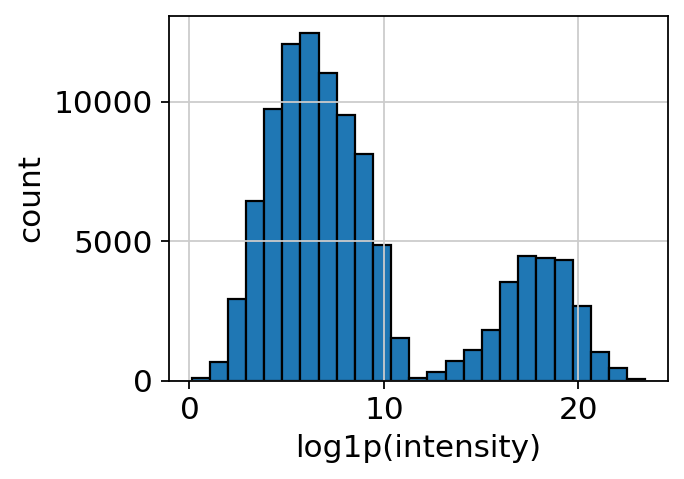

In [79]:
fig, ax = plt.subplots(figsize=(4, 3))

x = adata.layers["raw"].flatten()
x = x[~np.isnan(x)]
ax.hist(x, bins=25, edgecolor="black")
ax.set_xlabel("log1p(intensity)")
ax.set_ylabel("count")

In [80]:
adata.X = adata.layers["raw"].copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

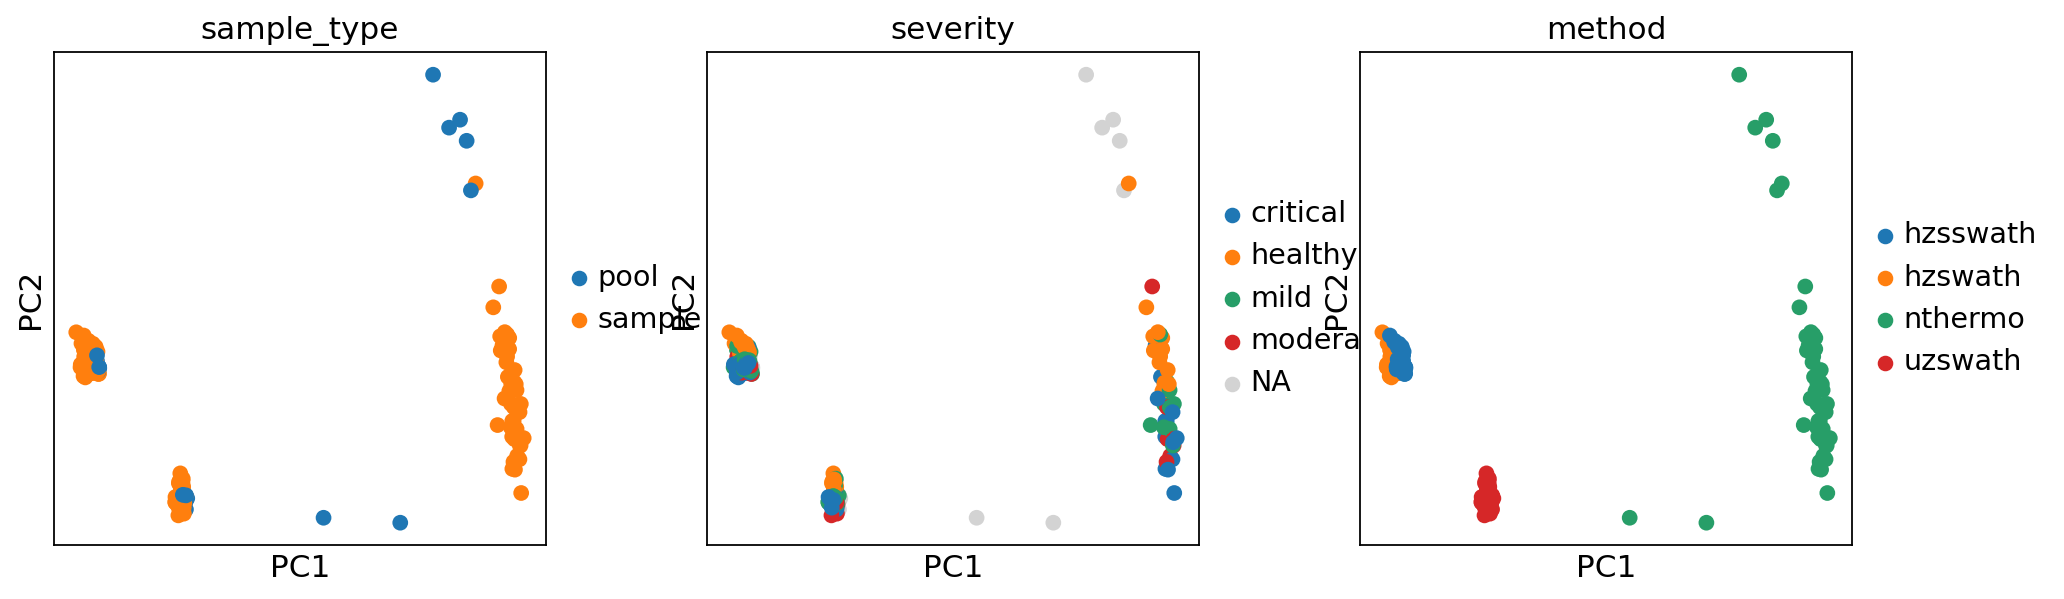

In [81]:
sc.pl.pca(adata, size=200, color=["sample_type", "severity", "method"], ncols=3)

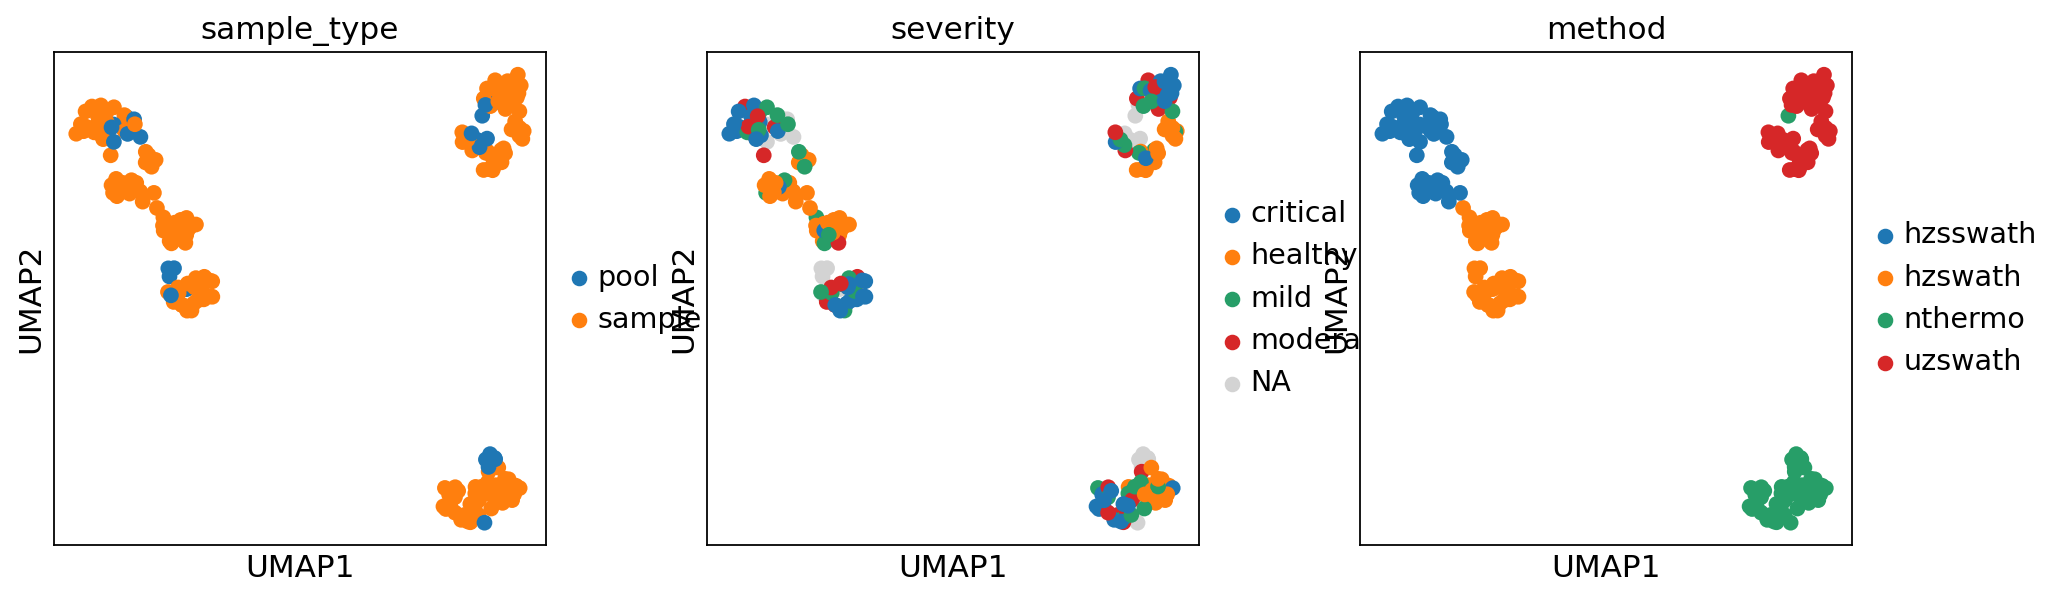

In [82]:
sc.pl.umap(adata, color=["sample_type", "severity", "method"], ncols=3, size=200)

In [83]:
adata.write("../../data/processed/wang2024_ospp_precursors.h5ad")